# Generate infection network

Notebook to produce the infection network as a function of time and save it as set of `.gml` files.

Assumes currently `.csv` inputs as per the variables `HUMANS_PATH` and `INFECTIONS_PATH` below.

Saves a version of the `HUMANS_PATH` `.csv` that contains the infections events.

Also creates plot of the network using `networkx` and `matplotlib`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.colors
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

## 0. Global variables

Paths:

In [2]:
HUMANS_PATH        = '../outputs/output-humans_time_course.csv'
INFECTIONS_PATH    = '../outputs/InfectionNetwork.csv'
EXPORT_GML_PATH    = '../outputs/network_static'
EXPORT_HUMANS_PATH = '../outputs/humans_infected_time_course.csv'

Colors:

In [3]:
SUSCEPTIBLE_COLOR = 'silver'
INFECTED_COLOR    = 'red'
RECOVERED_COLOR   = 'limegreen'
DEAD_COLOR        = 'black'

status_colors = {'S': SUSCEPTIBLE_COLOR,
                 'I': INFECTED_COLOR,
                 'R': RECOVERED_COLOR,
                 'D': DEAD_COLOR}

## 1. Read outputs

Humans timecourses:

In [4]:
humans_tc = pd.read_csv(HUMANS_PATH)

Get rid of `Unnamed: 0`:

In [5]:
humans_tc = humans_tc[['h_ID', 'loc', 'status', 'WasInfected', 'Diagnosed', 'Hospitalized', 'ICUed', 'time']]

In [6]:
humans_tc.head()

,h_ID,loc,status,WasInfected,Diagnosed,Hospitalized,ICUed,time
0,187,73,S,0,0,0,0,1
1,1087,389,S,0,0,0,0,1
2,194,75,S,0,0,0,0,1
3,1088,389,S,0,0,0,0,1
4,188,74,S,0,0,0,0,1


In [7]:
humans_tc.shape

(160000, 8)

Infection network:

In [8]:
infections = pd.read_csv(INFECTIONS_PATH)

Get rid of `Unnamed: 0`:

In [9]:
infections = infections[['ID', 'place_of_infection', 'time_of_infection', 'got_infected_by']]

Convert `got_infected_by` to `int`:

Using `pd.Int32Dtype()` in order to keep `NaN`s.

In [10]:
infections['got_infected_by'] = infections['got_infected_by'].astype(pd.Int32Dtype())

In [11]:
infections.head()

,ID,place_of_infection,time_of_infection,got_infected_by
0,187,146,35,940
1,1087,220,17,493
2,194,316,13,502
3,1088,146,17,1256
4,188,29,10,82


In [12]:
infections.shape

(1594, 4)

## 2. Generate static network

Network up to a certain time:

In [13]:
cutoff_time = 4

All infections up to that time except initial (`NaN`) infections:

In [14]:
infections_trimmed = infections[(infections['time_of_infection'] <= cutoff_time) & (infections['got_infected_by'].notna())]

In [15]:
infections_trimmed.head()

,ID,place_of_infection,time_of_infection,got_infected_by
16,195,76,2,196
323,115,44,2,114
559,242,92,1,243
874,872,323,3,873
879,873,323,1,875


Spreaders ranked by cumulative number of infections:

In [16]:
infections_trimmed.got_infected_by.value_counts(dropna = False)

575    4
390    3
647    3
875    3
80     3
176    2
393    2
983    2
82     1
175    1
114    1
652    1
243    1
650    1
873    1
980    1
196    1
NaN    0
Name: got_infected_by, dtype: Int64

In [17]:
humans_tc_with_infected = pd.merge(left = humans_tc,
                                   right = infections, 
                                   how = 'left',
                                   left_on = ['h_ID', 'time'],
                                   right_on = ['ID', 'time_of_infection']).drop(labels = 'ID', axis = 1, inplace = False)

In [18]:
humans_tc_with_infected.head()

,h_ID,loc,status,WasInfected,Diagnosed,Hospitalized,ICUed,time,place_of_infection,time_of_infection,got_infected_by
0,187,73,S,0,0,0,0,1,NaN,NaN,<NA>
1,1087,389,S,0,0,0,0,1,NaN,NaN,<NA>
2,194,75,S,0,0,0,0,1,NaN,NaN,<NA>
3,1088,389,S,0,0,0,0,1,NaN,NaN,<NA>
4,188,74,S,0,0,0,0,1,NaN,NaN,<NA>


Only humans at infection times:

In [19]:
humans_tc_with_infected[humans_tc_with_infected.got_infected_by.notna()]

,h_ID,loc,status,WasInfected,Diagnosed,Hospitalized,ICUed,time,place_of_infection,time_of_infection,got_infected_by
560,242,92,I,1,0,0,0,1,92.0,1.0,243
883,873,323,I,1,0,0,0,1,323.0,1.0,875
898,876,323,I,1,0,0,0,1,323.0,1.0,875
995,176,67,I,1,0,0,0,1,67.0,1.0,175
1175,980,353,I,1,0,0,0,1,353.0,1.0,983
...,...,...,...,...,...,...,...,...,...,...,...
60513,84,71,I,1,0,0,0,38,71.0,38.0,585
62298,388,142,I,1,0,0,0,39,146.0,39.0,939
65332,85,31,I,1,0,0,0,41,31.0,41.0,84
66048,1203,421,I,1,0,0,0,42,421.0,42.0,1202


In [20]:
humans_tc_with_infected.to_csv(EXPORT_HUMANS_PATH, sep = ";", index = False)

Convert `time_of_infection` and `place_of_infection` to `int`:

Using `pd.Int32Dtype()` in order to keep `NaN`s.

In [21]:
humans_tc_with_infected['time_of_infection'] = humans_tc_with_infected['time_of_infection'].astype(pd.Int32Dtype())
humans_tc_with_infected['place_of_infection'] = humans_tc_with_infected['place_of_infection'].astype(pd.Int32Dtype())

In [22]:
humans_tc_with_infected.shape

(160000, 11)

In [23]:
humans_tc_with_infected.head()

,h_ID,loc,status,WasInfected,Diagnosed,Hospitalized,ICUed,time,place_of_infection,time_of_infection,got_infected_by
0,187,73,S,0,0,0,0,1,<NA>,<NA>,<NA>
1,1087,389,S,0,0,0,0,1,<NA>,<NA>,<NA>
2,194,75,S,0,0,0,0,1,<NA>,<NA>,<NA>
3,1088,389,S,0,0,0,0,1,<NA>,<NA>,<NA>
4,188,74,S,0,0,0,0,1,<NA>,<NA>,<NA>


Status statistics at cutoff time:

In [24]:
humans_tc_with_infected[humans_tc_with_infected["time"] == cutoff_time].status.value_counts()

S    1559
I      40
R       1
Name: status, dtype: int64

Number of infections at `cutoff_time`, excluding initial infections (`NaN`):

In [25]:
humans_tc_with_infected[(humans_tc_with_infected["time"] == cutoff_time) & (humans_tc_with_infected["time_of_infection"] == cutoff_time)]

,h_ID,loc,status,WasInfected,Diagnosed,Hospitalized,ICUed,time,place_of_infection,time_of_infection,got_infected_by
5983,982,353,I,1,0,0,0,4,353,4,980
6100,651,241,I,1,0,0,0,4,241,4,652
6122,81,30,I,1,0,0,0,4,30,4,80


Generate edge list:

In [26]:
infection_events = list(zip(infections_trimmed['got_infected_by'], infections_trimmed['ID']))

In [27]:
infection_events

[(196, 195),
 (114, 115),
 (243, 242),
 (873, 872),
 (875, 873),
 (875, 874),
 (875, 876),
 (176, 174),
 (175, 176),
 (176, 177),
 (983, 980),
 (983, 981),
 (980, 982),
 (647, 648),
 (647, 649),
 (647, 650),
 (652, 651),
 (650, 652),
 (82, 79),
 (80, 81),
 (80, 82),
 (80, 83),
 (390, 389),
 (393, 391),
 (390, 392),
 (390, 393),
 (393, 394),
 (575, 576),
 (575, 577),
 (575, 578),
 (575, 580)]

Time-resolved, alternatively via `humans_tc_with_infected`:

In [28]:
infection_edges = dict()
times = np.unique(humans_tc_with_infected.time.values)

Generate `dict` of infection events at discrete times:

In [29]:
for time in times:
    infections_at_time = humans_tc_with_infected[(humans_tc_with_infected.time == time) & (humans_tc_with_infected.got_infected_by.notna())]
    # print(time, infections_at_time.shape)
    infection_edges[time] = list(zip(infections_at_time['got_infected_by'], infections_at_time['h_ID']))

In [30]:
infection_edges[1]

[(243, 242),
 (875, 873),
 (875, 876),
 (175, 176),
 (983, 980),
 (647, 650),
 (80, 83)]

Generate graphs:

In [31]:
infection_network_static = {time: nx.DiGraph(infection_edges[time]) for time in times}

Add all nodes so that not just the infected but also the susceptible are in the graph:

In [32]:
%%time
for time in times:
    infection_network_static[time].add_nodes_from(humans_tc_with_infected['h_ID'])

Wall time: 5.55 s


Draw graph at one time:

In [33]:
example_time = 2

In [34]:
edges = infection_network_static[example_time].edges()

In [35]:
len(edges)

11

In [36]:
out_degrees = [infection_network_static[example_time].out_degree()[edge[0]] for edge in edges]

In [37]:
max(out_degrees)

3

Define a colormap for the edges based on the degrees of the nodes (red = super spreader, green = low spreader):

In [38]:
cdict = {'red':   [(0.0, 0.0, 0.0),  # red increases
                   (1.0, 1.0, 1.0)],

         'green': [(0.0, 1.0, 1.0),  # green decreases
                   (1.0, 0.0, 0.0)],

         'blue':  [(0.0, 0.0, 0.0),  # no blue at all
                   (1.0, 0.0, 0.0)]}

red_green_cm = matplotlib.colors.LinearSegmentedColormap('RedGreen', cdict, max(out_degrees))

Get status of a node (not very safe because it depends on the expression returning only one value):

In [39]:
def get_status(human_ID, time):
    if pd.isnull(human_ID):
        status = 'S'
    elif human_ID not in humans_tc_with_infected.h_ID.values:
        status = 'S'
    else:
        status = humans_tc_with_infected[(humans_tc_with_infected.h_ID == human_ID) & (humans_tc_with_infected.time == time)].status.values[0]

    return status

Test the function:

In [40]:
get_status(214, cutoff_time)

'S'

In [41]:
%%time
node_colors = [status_colors[get_status(node, example_time)] for node in infection_network_static[example_time].nodes]

Wall time: 2.25 s


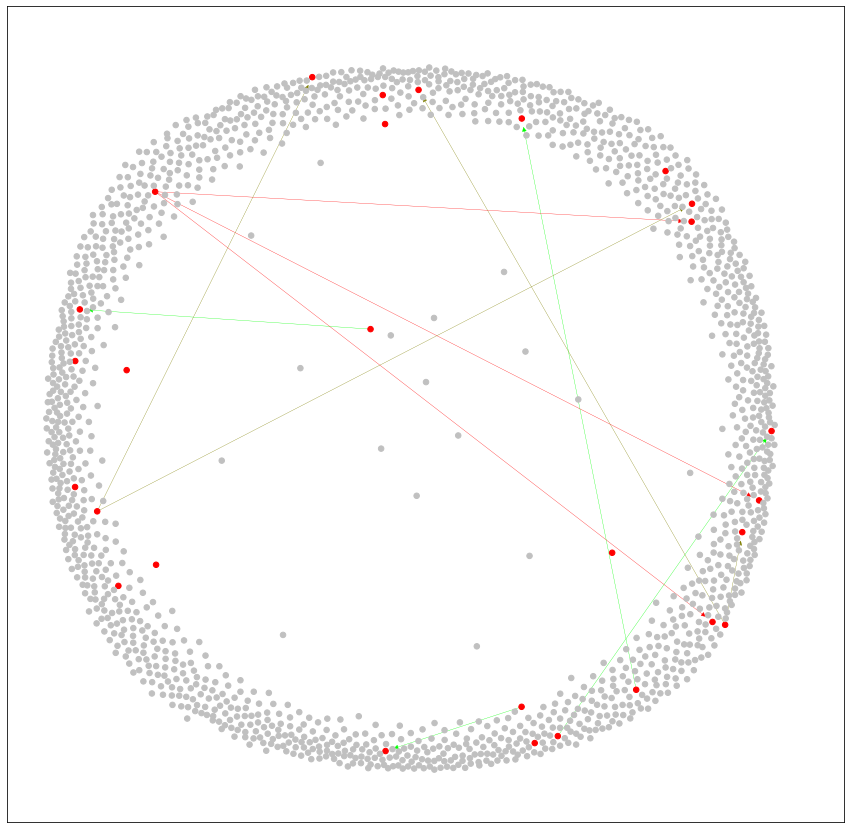

Wall time: 12.2 s


In [42]:
%%time
pos = nx.spring_layout(infection_network_static[1]) # fix the layout at one time
plt.figure(figsize = (15, 15))
nx.draw_networkx_nodes(infection_network_static[example_time], pos, node_color = node_colors, node_size = 30)
nx.draw_networkx_edges(infection_network_static[example_time], pos, width = 0.3, edge_color = out_degrees, edge_cmap = red_green_cm, arrows = True)
plt.show()

Save networks to `gml` (e.g. for visualization in Cytoscape):

In [43]:
%%time
to_string = lambda x: str(x)

for time in times:
    time_three_digit = str(time).zfill(3)
    nx.write_gml(infection_network_static[time], path = f"{EXPORT_GML_PATH}_{time_three_digit}.gml", stringizer = to_string)

Wall time: 858 ms


Careful, `gml` does not save the line widths or colors from the plot above.